# Read Features

In [1]:
from read_features import *
from scores import *
from collections import defaultdict,Counter
import shap
import joblib
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import auc, confusion_matrix
from copy import deepcopy

In [2]:
# display params
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_colwidth = None
pd.set_option("display.precision", 5)
cmap = sns.color_palette("mako", as_cmap= True)

In [3]:
def read_labels(set_name, data_dir = "./data", file_type = ".csv"):
    header = 'infer'
    names = None
    delimeter = ","
    if "tsv" in file_type:
        header = None
        names = ["Source", "label", "code", "sentence"]
        delimeter = "\t"
    df = pd.read_csv(os.path.join(data_dir, set_name+file_type), header=header, names=names, delimiter=delimeter)
    return df["sentence"], df["label"].values

In [4]:
# textual data
train_set_name, valid_set_name, test_set_name = ("in_domain_train", "in_domain_dev","out_of_domain_dev")
data_dir = "./data/";
file_type = ".csv" 
# feature tables
model_name = "bert-base-cased_finetuned"
heads="all";
layers=12
MAX_LEN=64
topological_thr=6
topological_features="s_e_v_c_b0b1"
feature_dir = "./features/bert-base-cased_finetuned/"

In [5]:
kwargs = dict(((k, eval(k)) for k in ("feature_dir", "model_name", "heads", "layers", "MAX_LEN", "topological_thr",  "topological_features" )))
X_train, X_valid, X_test = list(map(lambda x_: load_data(x_, **kwargs), [x_ for x_ in (train_set_name, valid_set_name, test_set_name)]))

Loading out_of_domain_dev features...: 100%|████████████████████████████████████████| 432/432 [00:04<00:00, 107.20it/s]


In [6]:
# H0_S_w Features
columns_new = ['h0_S_w_'+str(i[0]) + '_' + str(i[-1]) for i in itertools.product(range(12), range(layers))]
X_h0_train, X_h0_valid, X_h0_test = map(lambda x: pd.DataFrame(data=np.load(x + ".npy"),columns=columns_new), (train_set_name, valid_set_name, test_set_name) )

## Datasets

In [7]:
data_args = dict(((k, eval(k)) for k in ("data_dir", "file_type")))
(sents_train, y_train), (sents_valid, y_valid), (sents_test, y_test) = list(map(lambda x_: read_labels(x_, **data_args), 
                                                [x_ for x_ in (train_set_name, valid_set_name, test_set_name)]))

In [8]:
# feature tables
X_train = pd.concat([X_train, X_h0_train], axis = 1)
X_valid = pd.concat([X_valid, X_h0_valid], axis = 1)
X_test = pd.concat([X_test, X_h0_test], axis = 1)

# Shapley values

In [9]:
def score_mcc(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred)

excluded = {"Imperative", "Violations"}
def list_grammar_features(df):
    after = 'Acceptability'
    r = []
    take = False
    for c in df.columns:
        if take and c and c not in excluded:
            r.append(c)
        if c == after:
            take = True
    return r

def select_grammar_feature(XXX, yyy, name):
    idx = cola_gr_major[name] == 1
    Xf = XXX[idx].copy()
    yf = yyy[idx].copy()
    return idx, Xf, yf

In [10]:
cola_gr_major = pd.read_csv("https://www.dropbox.com/s/tjob1wepcxbug0f/CoLA_grammatical_annotations_major_features.tsv?dl=1", sep='\t', index_col=0)
cola_gr_major = cola_gr_major.reset_index()

In [11]:
# concatenate in_domain_dev and out_of_domain_dev for local Shapley values
XX = pd.concat([X_valid.loc[:, X_train.columns], X_test.loc[:, X_train.columns]], axis = 0).reset_index(drop=True)
yy = np.concatenate((y_valid, y_test), axis = 0)

In [12]:
# load saved model
clf_pca = joblib.load('grid_search_CV_100.pkl')
pca = clf_pca.best_estimator_.named_steps['reduce_dim']

Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator PCA from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator Pipeline from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [13]:
scl = clf_pca.best_estimator_.named_steps['scaler']
model = clf_pca.best_estimator_.named_steps['clf']
X_scaled_train = scl.transform(X_train.values)
X_shap_train = pca.transform(X_scaled_train)
model.fit(X_shap_train, y_train)
X_scaled_test = scl.transform(XX)
X_shap_test = pca.transform(X_scaled_test)
explainer = shap.LinearExplainer(model, X_shap_train)
shap_values = explainer.shap_values(X_shap_test)

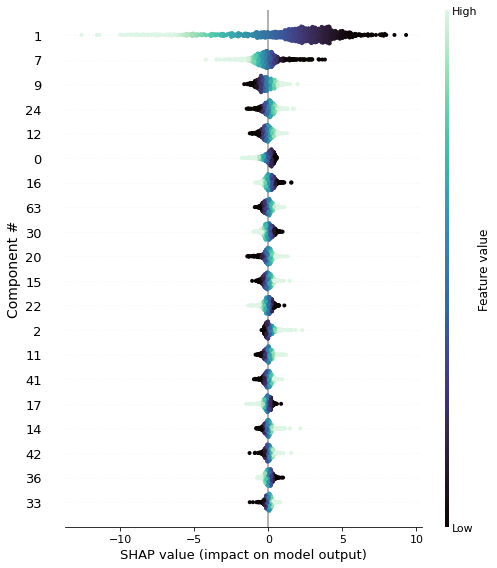

In [14]:
shap.summary_plot(shap_values, X_shap_test, 
                  cmap = cmap, plot_type = "dot", axis_color = "black",
                  show = False,feature_names=[str(i) for i in range(shap_values.shape[1])])
plt.ylabel("Component #")
font = {'size'   : 14,"family": "serif"}
plt.rc('font', **font)
plt.show()

In [15]:
pca_comp_imp = pd.DataFrame(shap_values)
shapley_important_comp = np.argsort(np.abs(pca_comp_imp.values).mean(0))[-20:][::-1]
mean_pca_scores = pd.DataFrame(data=np.mean(np.abs(shap_values[:,[shapley_important_comp]]), axis = 0).T, index =shapley_important_comp, columns = ["Mean(|SHAP value)"])
mean_pca_scores.index.name="PC#"
mean_pca_scores

,Mean(|SHAP value)
PC#,
1,3.17891
7,0.60145
9,0.44201
24,0.29602
12,0.27842
0,0.27392
16,0.24349
63,0.21812
30,0.21618


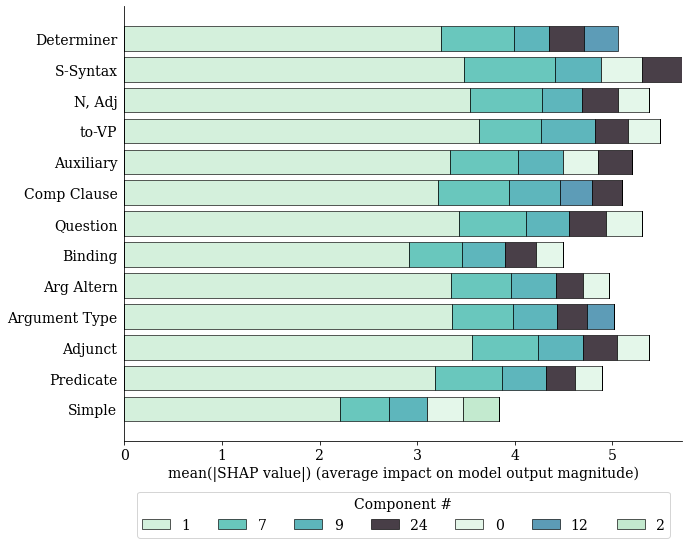

In [16]:
fig, ax = plt.subplots()
max_display = 5
all_phenomena = list_grammar_features(cola_gr_major)[1:]
y_pos = np.arange(len(all_phenomena))
left_pos = np.zeros(len(all_phenomena))
for p,f in enumerate(all_phenomena):
    phenomena_idx, _, _ = select_grammar_feature(XX, yy, f)
    phenomena_idx = XX[phenomena_idx].index
    feature_order = pd.DataFrame(shap_values[phenomena_idx, :])
    feature_inds = feature_order.loc[:,np.argsort(np.abs(feature_order.values).mean(0))[-max_display:]].columns[::-1].tolist()
    for ind,i in enumerate(feature_inds):
        global_shap_values = np.zeros(len(all_phenomena))
        global_shap_values[p] = np.abs(shap_values[phenomena_idx, i]).mean(0) 
        ax.barh(y_pos, global_shap_values, 0.8, left=left_pos, align='center',
                color=cmap.colors[::-10][i], label=i, edgecolor = "black", linewidth = 0.8, alpha = 0.8)
        left_pos += global_shap_values
handles, labels = ax.get_legend_handles_labels()
order = Counter(labels)
unique = sorted([(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]], 
                key = lambda x: order[x[-1]],reverse =True)
ax.legend(*zip(*unique),title = "Component #",frameon=True, ncol=len(unique),loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax.set_yticks(y_pos)
plt.gca().set_yticklabels(all_phenomena)
plt.gca().yaxis.set_ticks_position('none')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
plt.show()

## PC-to-y correlations

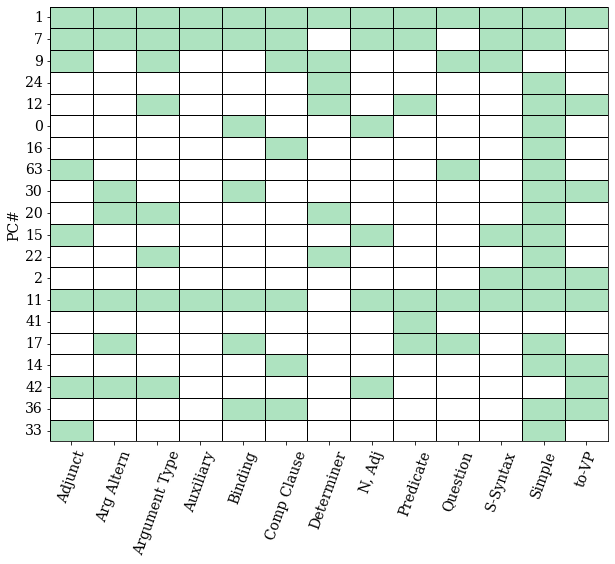

In [17]:
cc = {'Coef_': clf_pca.best_estimator_.named_steps['clf'].coef_[0]}
cc_idx = ['Coef_']
for f in all_phenomena:
    _, Xf, yf = select_grammar_feature(XX, yy, f)
    X_pca = pca.transform(scl.transform(Xf))
    r = [np.corrcoef(X_pca[:,i], yf)[0,1] for i in range(X_pca.shape[1])]
    cc[f'{f}'] = np.array(r)
corr_thr = 0.1
corr_display = pd.DataFrame(cc).iloc[shapley_important_comp,1:]
corr_display.index.name = 'PC#'
corr_display = corr_display.reindex(sorted(corr_display.columns), axis=1)
corr_display = corr_display.mask(corr_display.abs() >= corr_thr, 1)
sns.heatmap(corr_display, cmap=ListedColormap(['white', sns.color_palette("mako", n_colors = 10)[-1]]), linewidths=1,linecolor='black',cbar=False)
[plt.gca().spines[spine].set_visible(True) for spine in ["right", "bottom"]]
plt.xticks(rotation=70)
plt.yticks(rotation=0)
plt.show()

# Components structure

In [18]:
def sorted_features(v, X):
    """
    v - coeffs numpy vector,
    X - input data
    Returns data frame with names and values sorted by abs. values in desc order
    """
    idx = list(np.argsort(np.abs(v)))
    idx.reverse()
    df = pd.DataFrame([{'name': X_train.columns[j], 'idx': j, 'value': v[j]} for j in idx])
    return df

In [19]:
pca_not_imp = [3,6] # ex of the least important components
pca_features = [[f"{i}", str(sorted_features(pca.components_[i], X_train)["name"].values[:10])] for i in shapley_important_comp.tolist() + pca_not_imp ]
pca_inner_structure = pd.DataFrame(pca_features, columns = ["PC#", "Features"]).set_index("PC#")
pca_inner_structure

,Features
PC#,
1,['v_t0.5_11_9' 'v_t0.025_11_1' 'self_11_1' 'v_t0.05_11_9' 'v_t0.05_11_1'\n 'self_11_9' 'v_t0.05_11_10' 'v_t0.5_11_1' 'v_t0.025_11_9'\n 'v_t0.025_11_10']
7,['b1_t0.25_11_5' 'h1_n_b_l_t0.70_11_9' 'h1_n_b_l_t0.70_11_7' 'h1_s_11_0'\n 'h1_n_b_l_t0.70_11_6' 'h1_s_11_7' 'b1_t0.25_11_7' 'h1_n_b_l_t0.70_11_5'\n 'h1_s_11_9' 'h1_s_11_6']
9,['self_0_11' 'self_0_8' 'dot_1_9' 'v_t0.1_6_0' 'dot_0_0' 'self_3_0'\n 'beginning_7_10' 'next_4_11' 'beginning_2_7' 'dot_1_2']
24,['b0_t0.05_0_2' 'b0_t0.05_0_9' 'b0_t0.05_0_7' 'b0_t0.05_0_0'\n 's_t0.025_0_7' 's_t0.025_11_7' 's_t0.025_11_4' 'e_t0.75_1_10'\n 'h0_n_d_l_t0.25_1_10' 'e_t0.75_9_8']
12,['beginning_4_10' 'v_t0.05_8_3' 'beginning_3_10' 'v_t0.05_8_8'\n 'v_t0.1_8_3' 'beginning_5_3' 'beginning_5_2' 'next_8_8' 'v_t0.75_8_3'\n 'v_t0.025_3_7']
0,['s_t0.5_11_8' 's_t0.5_11_5' 's_t0.5_1_0' 's_t0.75_7_10' 's_t0.75_10_9'\n 's_t0.75_2_3' 's_t0.75_11_5' 's_t0.75_10_7' 's_t0.5_8_0' 's_t0.75_4_10']
16,['prev_8_2' 'beginning_3_3' 'self_0_4' 'v_t0.05_8_2' 'v_t0.025_8_2'\n 'v_t0.5_8_2' 'next_9_10' 'comma_8_2' 'b1_t0.1_8_2' 'comma_8_3']
63,['b0_t0.5_2_3' 'h0_n_d_m_t0.75_2_3' 'b0_t0.25_2_3' 'b0_t0.1_2_3'\n 'b0_t0.05_2_3' 'v_t0.75_1_4' 'h1_n_b_l_t0.95_8_5' 'h1_nb_8_5'\n 'h1_n_b_m_t0.25_8_5' 'h0_t_d_1_4']
30,['h1_n_b_m_t0.25_8_2' 'h1_nb_8_2' 'h1_n_b_l_t0.95_8_2' 'h1_s_8_2'\n 'next_2_8' 'prev_1_1' 'v_t0.1_6_10' 'b1_t0.25_11_4' 'h0_s_1_11'\n 'h1_t_b_8_2']


# PC1 structure

In [20]:
def sum2_ft_types(v, X):
    pca_selected = pd.DataFrame(v*v, columns = ["value"])
    pca_selected["feature"] = [name.split('_')[0] for name in X.columns]
    pca_selected["feature_type"] = pca_selected.feature.apply(lambda x: ft_types_rev[x])
    class_df = pca_selected.groupby("feature")[["value"]].sum().sort_values('value', ascending=False)
    type_df = pca_selected.groupby("feature_type")[["value"]].sum().sort_values('value', ascending=False)
    return class_df, type_df
def labels(df):
    return [topological_titles[text] if text in topological_titles.keys() else text for text in df.index]

In [21]:
ft_types = {'topological': set(topological_names),'barcode': set("h0_h1".split('_')),'template': set(template_feature_names)}
ft_types_rev = {f:t for t in ft_types for f in ft_types[t]}

In [22]:
i = 1
class_sums2, type_sums2 = sum2_ft_types(pca.components_[i], X_train)
print(f'Sum of squares of PCA{i} components grouped by feature class:')
display(class_sums2)
print(f'Sum of squares of PCA{i} components grouped by feature type:')
display(type_sums2)

Sum of squares of PCA1 components grouped by feature class:


,value
feature,
v,0.21212
h0,0.16600
h1,0.11654
e,0.11474
c,0.10432
b1,0.09795
b0,0.06864
self,0.03348
s,0.02970


Sum of squares of PCA1 components grouped by feature type:


,value
feature_type,
topological,0.62747
barcode,0.28254
template,0.08999


normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


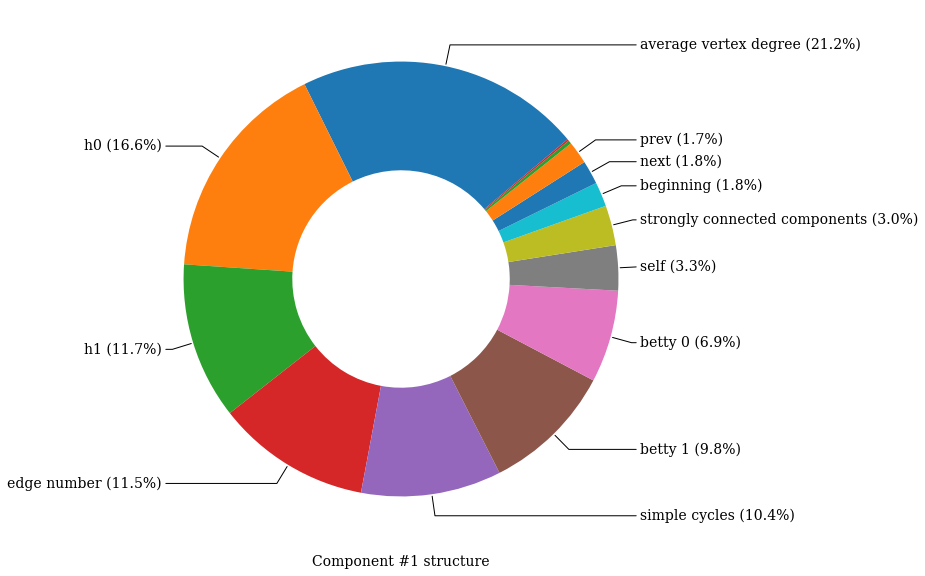

In [23]:
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw=dict(aspect="equal"))
wedges, texts= ax.pie(class_sums2["value"], wedgeprops=dict(width=0.5), startangle=40)
plt.ylabel("")
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-",
         color = 'black'),zorder=0, va="center")
plot_labels = labels(class_sums2)
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    y_label = 1.1*y
    text = plot_labels[i]
    value = round(class_sums2["value"][i]*100,1)
    if value > 1:
        ax.annotate(text + " (" + str(value) + "%)", xy=(x, y), xytext=(1.1*np.sign(x), y_label),
                    horizontalalignment=horizontalalignment, **kw)
ax.set_xlabel("Component #1 structure")
plt.show()

In [24]:
order_by_feature_group = []
[order_by_feature_group.extend(class_sums2.loc[type_,:].sort_values('value', ascending=False).index.tolist()) for type_ in ft_types.values()]
class_sums2 = class_sums2.loc[order_by_feature_group[::-1],:]

FixedFormatter should only be used together with FixedLocator


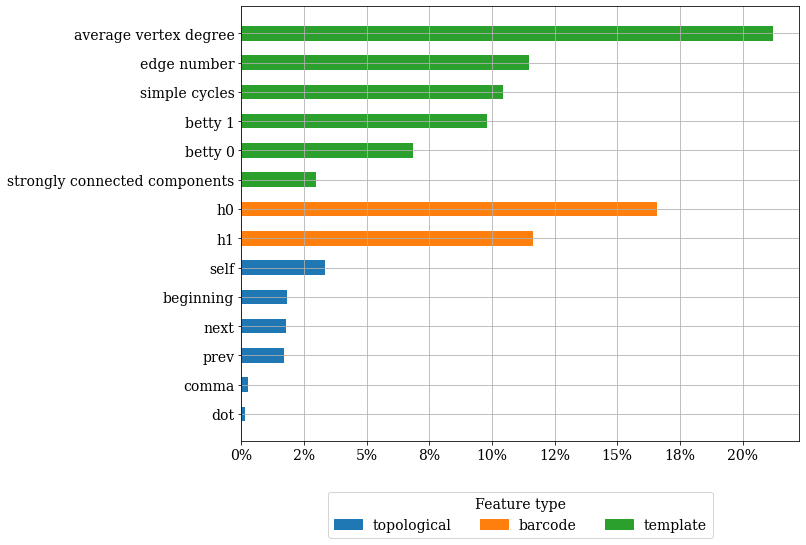

In [25]:
outer_colors = plt.get_cmap("tab10")(np.arange(type_sums2.index.shape[0]))
colors = []
[colors.extend([list(outer_colors[i])] * len(ft_types[type_])) for i,type_ in enumerate(type_sums2.index)]
plt.barh(labels(class_sums2), class_sums2['value'], color=colors, height = 0.5)
patches = [mpatches.Patch(color=outer_colors[i], label=t) for i,t in enumerate(type_sums2.index)]
plt.legend(handles=patches,title = "Feature type", ncol=len(patches),
                        loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax = plt.gca()
plt.grid()
vals = ['{:.0f}%'.format(x*100) for x in ax.get_xticks()]
ax.set_xticklabels(vals)
plt.show()

# Pipeline scorew with masked components

In [26]:
def mask_clf(clf, mask):
    clf_masked = deepcopy(clf)
    w = clf_masked.best_estimator_.named_steps['clf'].coef_
    idx_mask = np.ones(w.shape[1], dtype=bool)
    idx_mask[mask] = False
    w[:, idx_mask] = 0
    return clf_masked
def test_clf(clf, X, y):
    f = clf.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, f)
    auc_value = auc(fpr, tpr)
    y_pred = clf.predict(X)
    mcc = matthews_corrcoef(y, y_pred)
    acc = accuracy_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return acc, mcc, auc_value, tn, fp, fn, tp

In [27]:
for name_, subset in [('masked', [1]), ('masked', [1,7,9,24,12,0]),('full', clf_pca)]:
    clf_ = clf_pca
    if name_ == 'masked':
        clf_ = mask_clf(clf_pca, subset)
        print(f'PCA mask {subset}')
    else:
        print('Full PCA')
    yhat0 = clf_.predict_proba(X_train)[:, 1]
    thr_mcc, _, _ = print_thresholds(y_train, yhat0)
    yhat_valid = clf_.predict_proba(X_valid)[:, 1]
    y_pred_thr_mcc = np.array([1 if i >= thr_mcc else 0 for i in yhat_valid])
    print_scores(y_valid, y_pred_thr_mcc)
    yhat_out0 = clf_.predict_proba(X_test)[:, 1]
    y_pred_thr_mcc = np.array([1 if i >= thr_mcc else 0 for i in yhat_out0])
    print_scores(y_test, y_pred_thr_mcc)
    print("*"*20)

PCA mask [1]
Search for the best threshold by maximizing "matthews_corrcoef":
Threshold =	0.39458111406363894
Bal. Acc. =	0.9395640485207548
Accuracy =	0.9554438077417846
MCC score =	0.8920382522421985	

Search for the best threshold by maximizing "balanced_accuracy":
Threshold =	0.5186613426770801
Bal. Acc. =	0.9448484461988538
Accuracy =	0.9541574084902351
MCC score =	0.8899013001778242	

Bal. Acc. =	0.776
Accuracy =	0.837
MCC score =	0.6	

Bal. Acc. =	0.705
Accuracy =	0.791
MCC score =	0.482	

********************
PCA mask [1, 7, 9, 24, 12, 0]
Search for the best threshold by maximizing "matthews_corrcoef":
Threshold =	0.45402557596776194
Bal. Acc. =	0.9573914446100076
Accuracy =	0.9671383463922348
MCC score =	0.9207051936296416	

Search for the best threshold by maximizing "balanced_accuracy":
Threshold =	0.6141464192387478
Bal. Acc. =	0.9612668512789582
Accuracy =	0.9659688925271898
MCC score =	0.9186819137812113	

Bal. Acc. =	0.787
Accuracy =	0.843
MCC score =	0.615	

Bal. Acc. =

# Heads important for grammatical phenomenon

For penalty=$l1$ the LogisticRegression probability values are
$$p_i \sim \exp(X_{0 i}^T C^T w + c),$$ where
$X_{0}$ are input features, $C$ is a matrix of components, $w^T$ is a vector of Logistic Regression Coefficients (```estimator.coef_```) and $c$ is the intercept.

In [28]:
def select_and_group(df, selectby=None, groupby=None):
    """
    Function to select required grammar annotation(s)
    and then aggregate them by y_pred / y.
    """
    df = df.copy()
    if selectby is not None:
        for c in selectby:
            df = df[df[c] == selectby[c]].copy()
    df.insert(0, 'count', 1) # add "1" for counting
    return df.groupby(groupby).sum().reset_index()

def invert_values(df):
    """
    Make all head sum values positive if they are in agreement
    with y_pred, i.e. multiply values by -1 where y_pred == 0
    """
    for i in np.where(df['y_pred'] == 0)[0]:
        start_col = df.columns.to_list().index('head_0_0')
        for j in range(start_col, start_col + 144):
            df.at[i, df.columns[j]] *= -1

def collect_head_layer_matrix(df):
    sum_df = pd.DataFrame(df.sum()).T
    row = sum_df.loc[0]
    count = 1.0
    if 'count' in row.keys():
        count = row['count']
    m = np.zeros((12, 12))
    for name in row.keys():
        if name.startswith('head_'):
            _, layer, head = name.split('_')
            layer = int(layer)
            head = int(head)
            m[layer, head] = row[name] / count
    return pd.DataFrame(m)

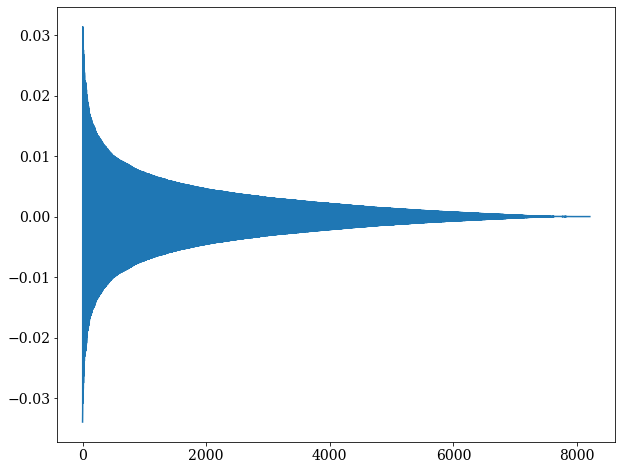

,name,idx,value
0,h0_S_w_10_6,8190,-0.03394
1,h0_S_w_11_9,8205,-0.03298
2,h0_S_w_10_2,8186,-0.03204
3,h0_S_w_10_10,8194,0.03137
4,h0_S_w_11_7,8203,-0.03084
5,h0_S_w_11_1,8197,-0.03061
6,h1_t_b_11_4,7094,0.03002
7,v_t0.5_11_8,5056,-0.02997
8,b1_t0.1_11_8,5072,0.02955
9,h0_S_w_10_3,8187,-0.02934


In [29]:
C = pca.components_.T / np.sqrt(pca.explained_variance_)
w = clf_pca.best_estimator_.named_steps['clf'].coef_
f = np.dot(C, w.T)
df = sorted_features(f.ravel(), X_train)
plt.plot(df['value'])
plt.show()
df[:30]

In [30]:
scl = clf_pca.best_estimator_.named_steps['scaler']
model = clf_pca.best_estimator_.named_steps['clf']
X_scaled_train = scl.transform(X_train.values)
X_shap_train = pca.transform(X_scaled_train)
model.fit(X_shap_train, y_train)
X_scaled_test = scl.transform(XX)
X_shap_test = pca.transform(X_scaled_test)

In [31]:
V = np.ndarray(XX.shape)
for i in range(XX.shape[0]):
    V[i,:] = X_scaled_test[i,:] * f.ravel()
V = pd.DataFrame(data=V, columns=X_train.columns)

In [32]:
Vc = V.copy()
Vc.columns = [f"head_{x.split('_')[-2]}_{x.split('_')[-1]}" for x in Vc.columns]
Vc = Vc.T
V = pd.concat((V, Vc.groupby(Vc.index)[Vc.columns].sum().T), axis = 1)

In [33]:
yhat0 = clf_pca.predict_proba(XX)[:, 1]
thr, y_pred = find_best_threshold(yy, yhat0, scoring='matthews_corrcoef')
V.insert(len(V.columns), 'y', yy)
V.insert(len(V.columns), 'y_hat', yhat0)
V.insert(len(V.columns), 'y_pred', y_pred)
V.insert(len(V.columns), 'y_correct', 1 * (y_pred == yy))

In [34]:
V = pd.concat([V, cola_gr_major.reset_index()], axis=1)
nfeat = X_train.columns.shape[0]
H = V[V.columns[nfeat:]].copy()
invert_values(H)

14it [00:01, 12.45it/s]


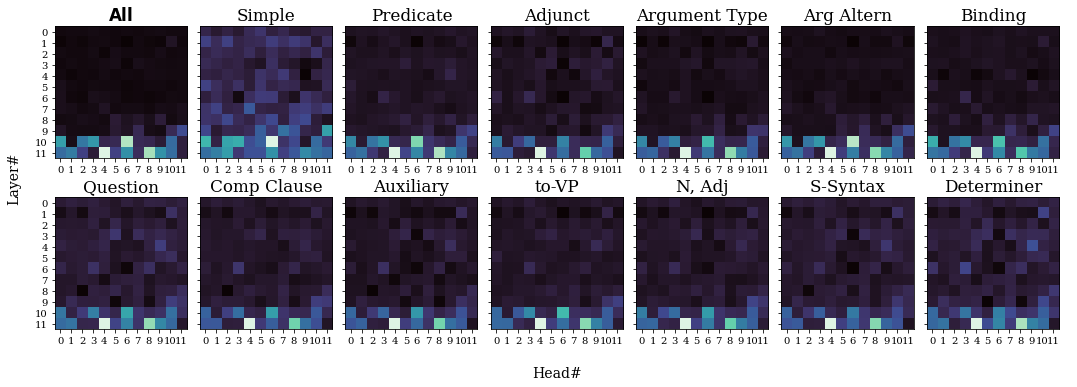

In [35]:
fig, axes = plt.subplots(nrows=2,ncols=7, figsize=(18, 6),sharey = True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i, gr in tqdm.tqdm(enumerate(['All'] + list_grammar_features(cola_gr_major)[1:])):
    title = gr
    if gr == 'All':
        title = r"$\bf{" + title + "}$"
        df = select_and_group(H, selectby=None, groupby=['y_pred', 'y', 'y_correct'])
    else:
        df = select_and_group(H, selectby={gr: 1}, groupby=['y_pred', 'y', 'y_correct'])
    m = collect_head_layer_matrix(df)
    vmin = np.min(m.values, axis=(0,1))
    vmax = np.max(m.values, axis=(0,1))
    ax = axes[i//7, i%7]
    ax.set_title(title)
    im = ax.imshow(m,cmap=cmap, vmin=vmin, vmax=vmax)
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(labelsize = 10)
    ax.set_xticks([i for i in range(12)])
    ax.set_yticks([i for i in range(12)])
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Head#")
plt.ylabel("Layer#")
plt.xticks(fontsize=14)
plt.title("")
plt.show()

In [36]:
V.insert(len(V.columns), 'sum_neg', 0.0)
V.insert(len(V.columns), 'sum_pos', 0.0)
V.insert(len(V.columns), 'sum_all', 0.0)
V.insert(len(V.columns), 'sum_abs', 0.0)
for i in range(V.shape[0]):
    col = V.loc[i].T[:len(X_train.columns)]
    col = col.to_frame(name='v')
    pos = sum(col['v'].apply(lambda x: x if x > 0 else 0))
    neg = sum(col['v'].apply(lambda x: x if x < 0 else 0))
    V.at[i, 'sum_pos'] = pos
    V.at[i, 'sum_neg'] = neg
    V.at[i, 'sum_all'] = pos + neg
    V.at[i, 'sum_abs'] = pos - neg

In [37]:
errs = V[V['y_correct'] == 0][['sum_neg', 'sum_pos', 'sum_all', 'sum_abs', 'y_hat', 'y', 'y_pred', 'Sentence']]

In [38]:
# the most arguable entities (positive voting ~ negative voting)
errs.sort_values('sum_abs', inplace=True, ascending=False)
errs.head(15)

,sum_neg,sum_pos,sum_all,sum_abs,y_hat,y,y_pred,Sentence
674,-23.89342,24.36134,0.46793,48.25476,0.82468,0,1,Gould's performance of Bach on the piano doesn't please me anywhere as much as Ross's on the harpsichord.
589,-18.91667,23.91607,4.99940,42.83274,0.99772,0,1,"The TA's have been arguing about whether some student or other should pass, but I can't now remember which one."
655,-22.17261,20.40753,-1.76508,42.58014,0.33522,1,0,"Max seemed to be trying to begin to love Harriet, and Fred to be trying to begin to love Sue."
584,-16.95583,22.35397,5.39815,39.30980,0.99847,0,1,"Sandy was trying to work out which students would be able to solve a certain problem, but she wouldn't tell us which one she was trying to work out which students would be able to solve."
603,-20.71883,18.34334,-2.37549,39.06217,0.21500,1,0,"The administration has issued a statement that it is willing to meet a student group, but I'm not sure which one."
692,-23.40073,14.56937,-8.83136,37.97010,0.00043,1,0,This is the senator to whose mother's friend's sister's I sent the letter.
657,-17.37187,19.16249,1.79062,36.53435,0.94640,0,1,"Max seemed to be trying to force Ted to leave the room, and Walt to stay a little longer."
549,-16.76883,19.03847,2.26964,35.80730,0.96611,0,1,"Each of the performers came in, but were sitting so far back that we couldn't see who."
670,-18.93168,16.38109,-2.55059,35.31277,0.18692,1,0,Bill's funny story about Sue and Max's boring one about Kathy both amazed me.
389,-21.59979,11.05668,-10.54310,32.65647,0.00008,1,0,"Everybody who attended last week's huge rally, whoever they were, signed the petition."


In [39]:
# FP with max. sum_all and y_hat (classified as unacceptable instead of acceptable)
errs.sort_values('sum_all', inplace=True, ascending=False)
errs.head(15)

,sum_neg,sum_pos,sum_all,sum_abs,y_hat,y,y_pred,Sentence
1040,-4.57914,10.12655,5.54741,14.70570,0.99868,0,1,John bought a dog for himself to play with.
584,-16.95583,22.35397,5.39815,39.30980,0.99847,0,1,"Sandy was trying to work out which students would be able to solve a certain problem, but she wouldn't tell us which one she was trying to work out which students would be able to solve."
1022,-8.47162,13.70516,5.23354,22.17679,0.99819,0,1,It was believed to be illegal by them to do that.
589,-18.91667,23.91607,4.99940,42.83274,0.99772,0,1,"The TA's have been arguing about whether some student or other should pass, but I can't now remember which one."
395,-6.33502,10.87205,4.53702,17.20707,0.99638,0,1,"You may pick every flower, but leave a few for Mary."
631,-5.48570,9.82679,4.34109,15.31248,0.99560,0,1,Chocolate eggs were hidden from each other by the children.
884,-7.64514,11.84075,4.19561,19.48589,0.99491,0,1,Protect you!
605,-6.95285,11.00100,4.04816,17.95385,0.99411,0,1,Agnes wondered how John could eat but it's not clear what.
304,-5.91547,9.85494,3.93947,15.77041,0.99344,0,1,Which house does your friend live?
585,-8.82664,12.69545,3.86881,21.52210,0.99296,0,1,"John and someone were dancing together, but I don't know who."


In [40]:
# FN with min. sum_all and y_hat (classified as acceptable instead of unacceptable)
errs.sort_values('sum_all', inplace=True, ascending=True)
errs.head(15)

,sum_neg,sum_pos,sum_all,sum_abs,y_hat,y,y_pred,Sentence
579,-18.67327,7.81335,-10.85992,26.48662,0.00006,1,0,"He shouted again, but I don't know who to."
389,-21.59979,11.05668,-10.54310,32.65647,0.00008,1,0,"Everybody who attended last week's huge rally, whoever they were, signed the petition."
398,-17.14425,7.52590,-9.61835,24.67015,0.00020,1,0,The man who Mary loves and Sally hates computed my tax.
692,-23.40073,14.56937,-8.83136,37.97010,0.00043,1,0,This is the senator to whose mother's friend's sister's I sent the letter.
580,-17.99904,9.38795,-8.61109,27.38699,0.00054,1,0,"She was dancing with somebody, but I don't know who with."
544,-16.74273,8.18496,-8.55778,24.92769,0.00057,1,0,Joan ate dinner with someone but I don't know who with.
985,-15.65082,7.57003,-8.08080,23.22085,0.00091,1,0,On whom are you counting to incriminate himself?
652,-17.20278,10.27255,-6.93023,27.47533,0.00287,1,0,"Bob tried to wash himself, and Mary to read the funnies."
266,-12.68810,5.83402,-6.85407,18.52212,0.00310,1,0,It is a golden hair.
232,-11.64830,5.31821,-6.33009,16.96651,0.00522,1,0,John bought a book on the table.


# Important components for minor phenomena

In [41]:
cola_gr_minor = pd.read_csv("https://www.dropbox.com/s/tn3m23hk9vs9x8e/CoLA_grammatical_annotations_minor_features.tsv?dl=1", sep='\t', index_col=0)
cola_gr_minor = cola_gr_minor.reset_index()

In [42]:
H_minor = pd.concat([H, cola_gr_minor[list(set(cola_gr_minor.columns[5:])-set(H.columns))]],axis = 1)
minor_excluded_phenomena = excluded|{"Extra", "Violation"}

In [43]:
N = 5
minor_ph_comp = []
for p in cola_gr_minor.columns[4:]:
    ecluded_minor = [True if e in p else False for e in minor_excluded_phenomena]
    if sum(ecluded_minor): continue;
    p_entity = cola_gr_minor[cola_gr_minor[p] == 1]
    ii = p_entity.index
    y_p_true = p_entity["Acceptability"].values
    y_p_pred = y_pred[ii]
    pca_comp_imp = pd.DataFrame(shap_values[ii, :])
    components_imp = pca_comp_imp.loc[:,np.argsort(np.abs(pca_comp_imp.values).mean(0))[-N:]].columns[::-1].tolist()
    df_group = select_and_group(H_minor, selectby={p: 1}, groupby=['y_pred', 'y', 'y_correct'])
    heads_log_reg = collect_head_layer_matrix(df_group).values
    heads_log_reg_sorted = np.unravel_index(np.argsort(np.abs(heads_log_reg), axis=None), heads_log_reg.shape)
    heads_log_reg = [str(heads_log_reg_sorted[0][::-1][x]) + "_" + str(heads_log_reg_sorted[1][::-1][x]) for x in range(N)]
    mcc_p_score = score_mcc(y_p_true, y_p_pred)
    minor_ph_comp.append([p + " (" + str(ii.shape[0]) + ")", sorted(components_imp), round(mcc_p_score, 3), heads_log_reg])
imp_comp_head_minor = pd.DataFrame(minor_ph_comp, 
                                   columns = ["phenomena(#)", "component:max var direction",  
                                              "MCC score", "top heads (log_reg coef)"])

In [44]:
imp_comp_head_minor = imp_comp_head_minor.astype(str).groupby(["component:max var direction", "phenomena(#)"]).sum()
imp_comp_head_minor.head(50)

MCC score  \
component:max var direction phenomena(#)                       
[0, 1, 2, 7, 9]             Simple (87)                0.648   
[0, 1, 7, 11, 24]           Island (22)                0.598   
[0, 1, 7, 9, 12]            Emb Q (99)                 0.217   
                            Neg (111)                  0.238   
[0, 1, 7, 9, 14]            NNCompd (35)               0.603   
[0, 1, 7, 9, 20]            Frag/Paren (9)             0.357   
[0, 1, 7, 9, 24]            Binding:Other (62)          0.58   
                            CP Arg NP/AP (26)          0.318   
                            Complex QP (80)            0.277   
                            Compx NP (106)             0.542   
                            Control (80)               0.577   
                            Coord (158)                0.317   
                            Copula (187)               0.558   
                            Deep Embed (30)            0.512   
                            Deverbal (53)              0.432   
                            Dislocation (56)           0.385   
                            Drop Arg (112)             0.692   
                            Ellipsis/Anaphor (118)     0.228   
                            Info Struc (31)            0.392   
                            Locative (69)              0.552   
                            Misc (75)                   0.36   
                            Modal (134)                 0.44   
                            NP Adjunct (52)            0.458   
                            PPArg-NP/AP (81)           0.727   
                            Particle (33)              0.383   
                            Partitive (18)             0.391   
                            Psuedo-Aux (26)            0.281   
                            Quantifier (139)           0.474   
                            RC (76)                    0.501   
                            Rel NP (65)                0.681   
                            S-Adjunct (30)             0.671   
                            Temporal (49)              0.511   
                            Trans Adj (39)             0.304   
                            Trans NP (21)              0.316   
                            VP Adjunct (162)           0.411   
                            VP arg-NP/AP (33)          0.398   
[1, 7, 16, 22, 41]          Comparative (25)           0.421   
[1, 7, 9, 11, 16]           Result/Depictive (26)      0.364   
[1, 7, 9, 12, 16]           Non-finite CP (24)         0.542   
                            Passive (114)              0.697   
[1, 7, 9, 12, 22]           by-Phrase (58)             0.669   
[1, 7, 9, 12, 24]           Add Arg (91)               0.695   
                            Aux (201)                  0.519   
                            Binding:Refl (60)          0.606   
                            CP Arg VP (110)            0.505   
                            Expletive (78)             0.622   
                            High Arity (253)            0.63   
                            No C-izer (41)             0.311   
                            Oblique (141)              0.613   
                            PP Arg-VP (242)             0.59   

                                                                     top heads (log_reg coef)  
component:max var direction phenomena(#)                                                       
[0, 1, 2, 7, 9]             Simple (87)              ['10_6', '10_0', '10_3', '10_2', '9_11']  
[0, 1, 7, 11, 24]           Island (22)              ['11_4', '10_6', '11_8', '10_0', '10_3']  
[0, 1, 7, 9, 12]            Emb Q (99)               ['11_4', '11_8', '10_6', '10_3', '11_9']  
                            Neg (111)                ['11_4', '11_8', '11_9', '10_6', '11_6']  
[0, 1, 7, 9, 14]            NNCompd (35)             ['11_4', '11_8', '10_3', '9_10', '11_6']  
[0, 1, 7, 9, 20]            Frag/Paren (9)        